<a href="https://colab.research.google.com/github/sesmael/ECGR-4105/blob/main/Homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
################################
########### Problem 1 ##########
################################
import torch
import matplotlib.pyplot as plt

# temperature data
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c, dtype=torch.float32)
t_u = torch.tensor(t_u, dtype=torch.float32)



In [5]:
# Normalize input data
t_u_normalized = (t_u - t_u.mean()) / t_u.std()

# Nonlinear model definition
def model(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

# Loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

# training loop with gradient clipping for nonlinear model
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        if torch.isnan(loss):
            print(f"Loss is NaN at epoch {epoch}. Stopping training.")
            break
        loss.backward()
        with torch.no_grad():
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)  # Clip gradients
            params -= learning_rate * params.grad
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss {loss.item()}")
    return params

In [6]:
# Train nonlinear model with different learning rates
learning_rates = [0.01, 0.001, 0.1, 0.0001]
all_trained_params = []
best_loss = float('inf')
best_params = None

print("\n--- Training Nonlinear Models with Different Learning Rates ---\n")
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    params = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)  # Initialize w2, w1, b
    trained_params = training_loop(
        n_epochs=5000,
        learning_rate=lr,
        params=params,
        t_u=t_u_normalized,
        t_c=t_c
    )
    final_loss = loss_fn(model(t_u_normalized, *trained_params), t_c).item()
    print(f"Final Loss for lr {lr}: {final_loss}")
    all_trained_params.append((lr, trained_params, final_loss))
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = trained_params


--- Training Nonlinear Models with Different Learning Rates ---


Training with learning rate: 0.01
Epoch 500, Loss 67.40294647216797
Epoch 1000, Loss 14.731609344482422
Epoch 1500, Loss 2.1185617446899414
Epoch 2000, Loss 2.090721368789673
Epoch 2500, Loss 2.09071946144104
Epoch 3000, Loss 2.09071946144104
Epoch 3500, Loss 2.09071946144104
Epoch 4000, Loss 2.09071946144104
Epoch 4500, Loss 2.09071946144104
Epoch 5000, Loss 2.09071946144104
Final Loss for lr 0.01: 2.09071946144104

Training with learning rate: 0.001
Epoch 500, Loss 171.32086181640625
Epoch 1000, Loss 156.2088623046875
Epoch 1500, Loss 142.05816650390625
Epoch 2000, Loss 128.84080505371094
Epoch 2500, Loss 116.52639770507812
Epoch 3000, Loss 105.08187866210938
Epoch 3500, Loss 94.47148895263672
Epoch 4000, Loss 84.65723419189453
Epoch 4500, Loss 75.59880065917969
Epoch 5000, Loss 67.25463104248047
Final Loss for lr 0.001: 67.23863983154297

Training with learning rate: 0.1
Epoch 500, Loss 2.090719699859619
Epoch 1000, 

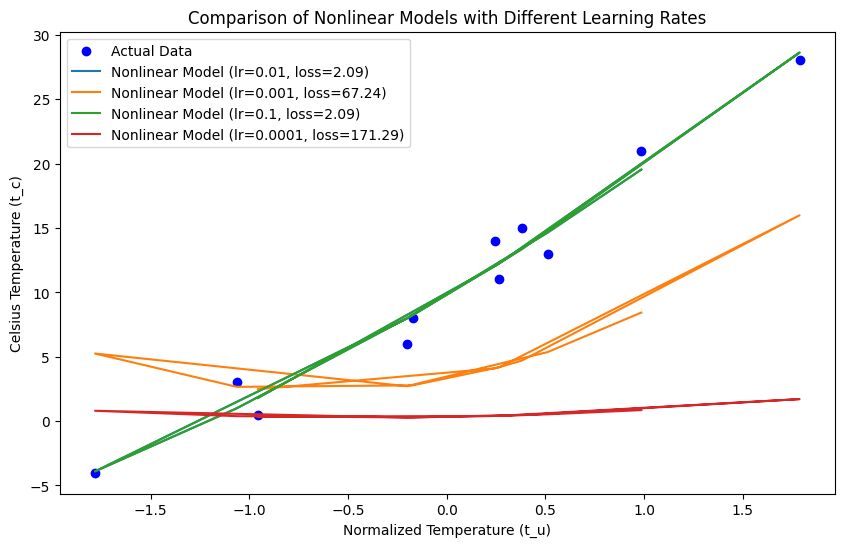


--- Training Linear Model ---

Epoch 500, Linear Model Loss: 2.9276468753814697
Epoch 1000, Linear Model Loss: 2.927645206451416
Epoch 1500, Linear Model Loss: 2.927645206451416
Epoch 2000, Linear Model Loss: 2.927645206451416
Epoch 2500, Linear Model Loss: 2.927645206451416
Epoch 3000, Linear Model Loss: 2.927645206451416
Epoch 3500, Linear Model Loss: 2.927645206451416
Epoch 4000, Linear Model Loss: 2.927645206451416
Epoch 4500, Linear Model Loss: 2.927645206451416
Epoch 5000, Linear Model Loss: 2.927645206451416


In [7]:
# Visualization: All nonlinear models
plt.figure(figsize=(10, 6))
plt.scatter(t_u_normalized.numpy(), t_c.numpy(), label="Actual Data", color="blue")

for lr, params, loss in all_trained_params:
    predictions = model(t_u_normalized, *params)
    plt.plot(
        t_u_normalized.numpy(),
        predictions.detach().numpy(),
        label=f"Nonlinear Model (lr={lr}, loss={loss:.2f})"
    )

plt.xlabel("Normalized Temperature (t_u)")
plt.ylabel("Celsius Temperature (t_c)")
plt.title("Comparison of Nonlinear Models with Different Learning Rates")
plt.legend()
plt.show()

# Linear model definition
def linear_model(t_u, w, b):
    return w * t_u + b

# Linear model training loop
def train_linear_model(n_epochs, learning_rate, t_u, t_c):
    w = torch.tensor(0.0, requires_grad=True)
    b = torch.tensor(0.0, requires_grad=True)
    optimizer = torch.optim.SGD([w, b], lr=learning_rate)

    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        t_p = linear_model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Linear Model Loss: {loss.item()}")

    return w.detach(), b.detach()

# Train the linear model
print("\n--- Training Linear Model ---\n")
linear_w, linear_b = train_linear_model(n_epochs=5000, learning_rate=0.01, t_u=t_u_normalized, t_c=t_c)

# Generate predictions using the trained linear model
linear_predictions = linear_model(t_u_normalized, linear_w, linear_b).detach().numpy()

# Generate predictions for the best nonlinear model
nonlinear_predictions = model(t_u_normalized, *best_params).detach().numpy()


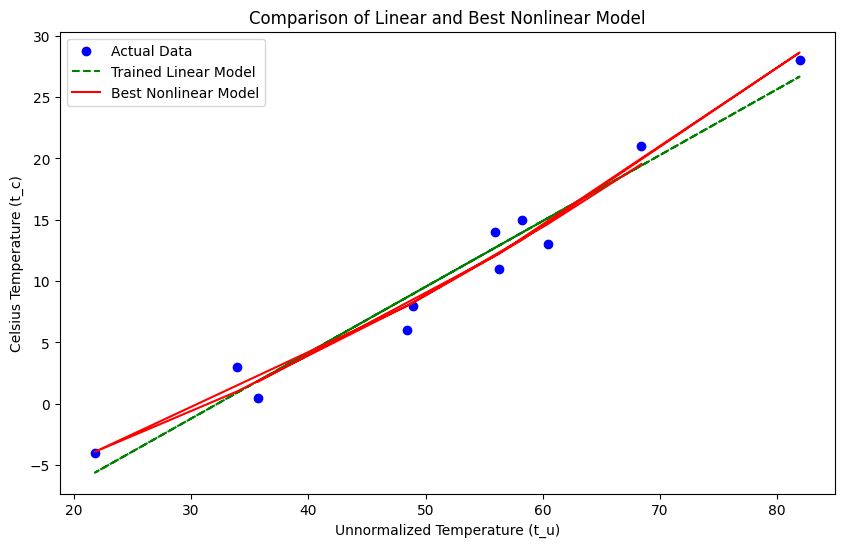

Best Nonlinear Model Parameters: tensor([0.8019, 9.1034, 9.7710], requires_grad=True)
Best Nonlinear Loss: 2.09071946144104
Trained Linear Model Parameters: w = 9.034883499145508, b = 10.499978065490723


In [8]:
# Visualization: Best nonlinear model vs linear model
plt.figure(figsize=(10, 6))
plt.scatter(t_u.numpy(), t_c.numpy(), label="Actual Data", color="blue")
plt.plot(t_u.numpy(), linear_predictions, label="Trained Linear Model", linestyle="--", color="green")
plt.plot(t_u.numpy(), nonlinear_predictions, label="Best Nonlinear Model", color="red")
plt.xlabel("Unnormalized Temperature (t_u)")
plt.ylabel("Celsius Temperature (t_c)")
plt.title("Comparison of Linear and Best Nonlinear Model")
plt.legend()
plt.show()

# Print best parameters and losses
print(f"Best Nonlinear Model Parameters: {best_params}")
print(f"Best Nonlinear Loss: {best_loss}")
print(f"Trained Linear Model Parameters: w = {linear_w.item()}, b = {linear_b.item()}")



Training with learning rate: 0.1
Epoch [500/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [1000/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [1500/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [2000/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [2500/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [3000/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [3500/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [4000/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [4500/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000
Epoch [5000/5000], Training Loss: 1350008045568.0000, Validation Loss: 2292721647616.0000

Training with learning rate: 0.01
Epoch [500/5000], Training Loss:

<Figure size 1200x600 with 0 Axes>

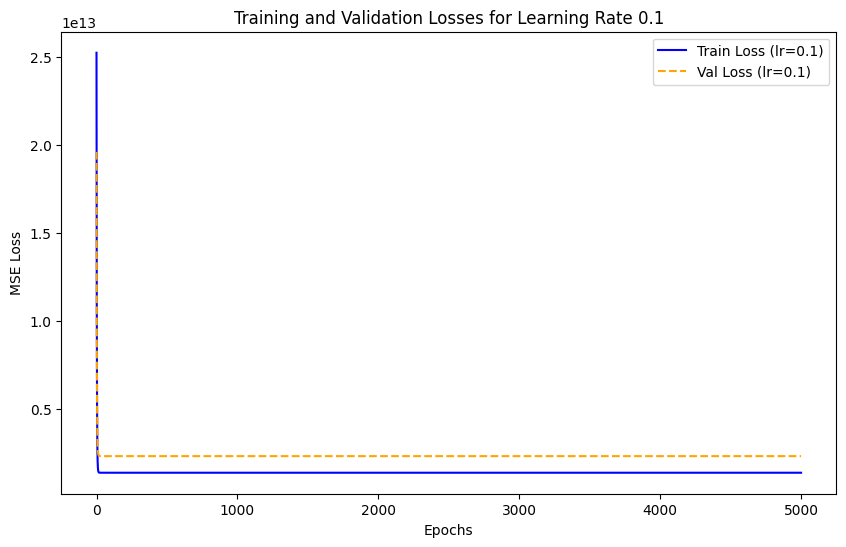

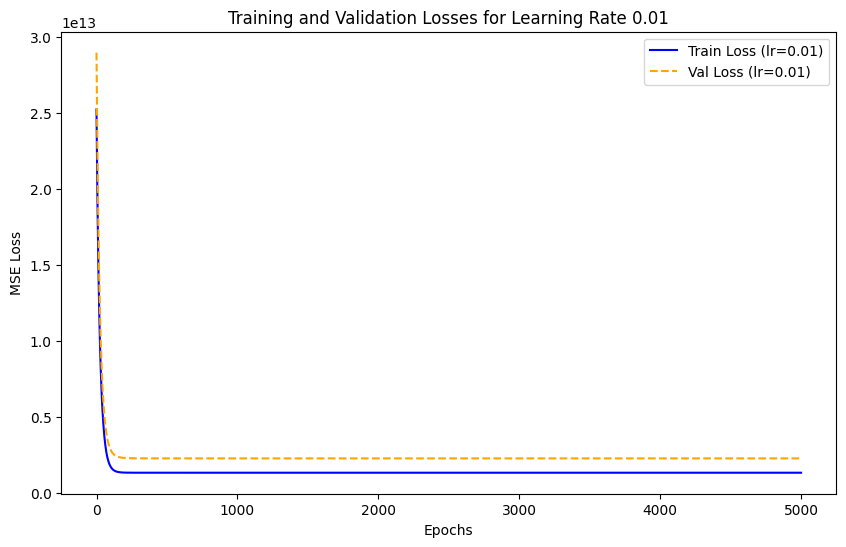

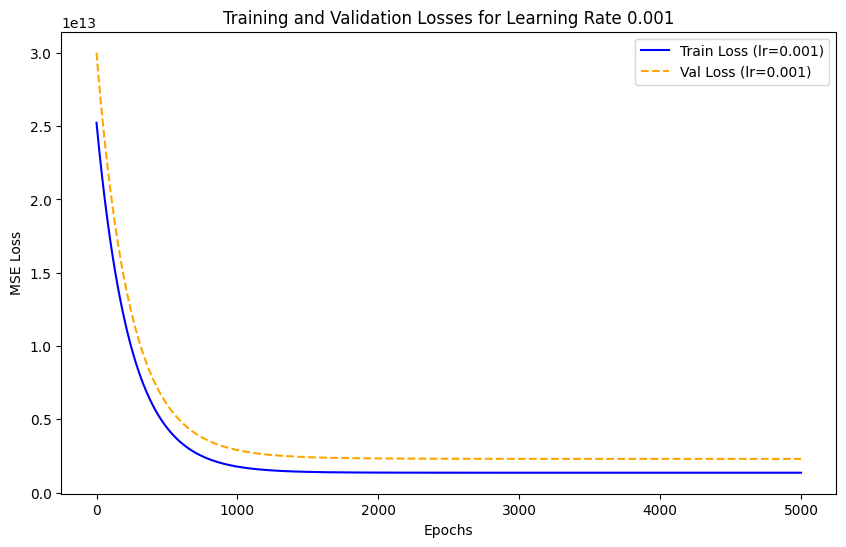

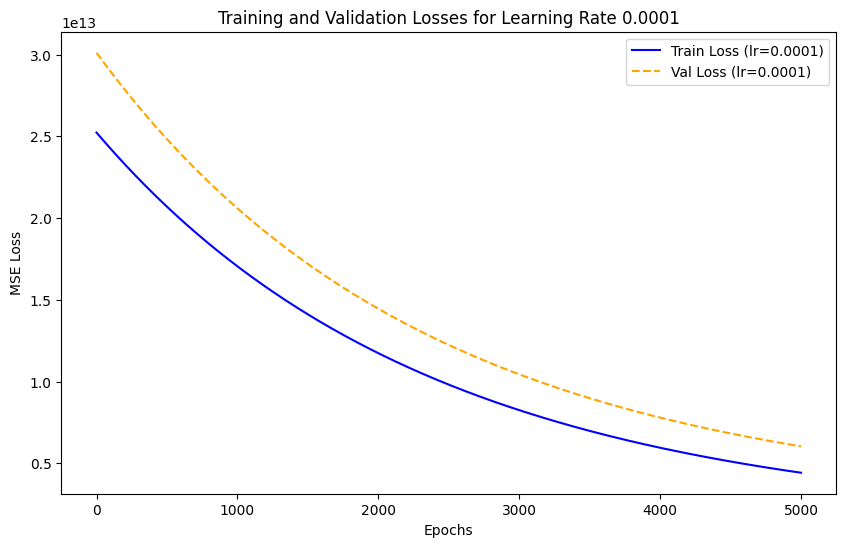


Best Validation Loss from current model: 2292721647616.0000


In [11]:
################################
########### Problem 2 ##########
################################
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'
df = pd.read_csv(url)

# Select relevant features and target variable
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
target = 'price'

# Handle missing values if any
df = df.dropna(subset=features + [target])

# Split the data into training and validation sets (80% training, 20% validation)
X = df[features].values
y = df[target].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_tensor.shape[1]
criterion = nn.MSELoss()

# Training function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, n_epochs=5000, report_interval=500):
    train_losses = []
    val_losses = []
    for epoch in range(1, n_epochs + 1):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Report losses
        if epoch % report_interval == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    return train_losses, val_losses

# Training with different learning rates and store losses
learning_rates = [0.1, 0.01, 0.001, 0.0001]
best_val_loss = float('inf')
best_model_state = None
all_train_losses = {}
all_val_losses = {}

for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')
    model = LinearRegressionModel(input_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses, val_losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

    # Store losses for plotting
    all_train_losses[lr] = train_losses
    all_val_losses[lr] = val_losses

    # Check if this is the best model
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model.state_dict()

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(12, 6))
# Plot separate graphs for each learning rate
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_losses[lr], label=f'Train Loss (lr={lr})', color='blue')
    plt.plot(all_val_losses[lr], linestyle='--', label=f'Val Loss (lr={lr})', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title(f'Training and Validation Losses for Learning Rate {lr}')
    plt.legend()
    plt.show()

# Load the best model
best_model = LinearRegressionModel(input_dim)
best_model.load_state_dict(best_model_state)

# Print the best validation loss
print(f'\nBest Validation Loss from current model: {best_val_loss:.4f}')



Training with learning rate: 0.1
Epoch [500/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [1000/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [1500/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [2000/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [2500/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [3000/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [3500/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [4000/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [4500/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000
Epoch [5000/5000], Training Loss: 968358297600.0000, Validation Loss: 1754319159296.0000

Training with learning rate: 0.01
Epoch [500/5000], Training Loss: 968365113

<Figure size 1200x600 with 0 Axes>

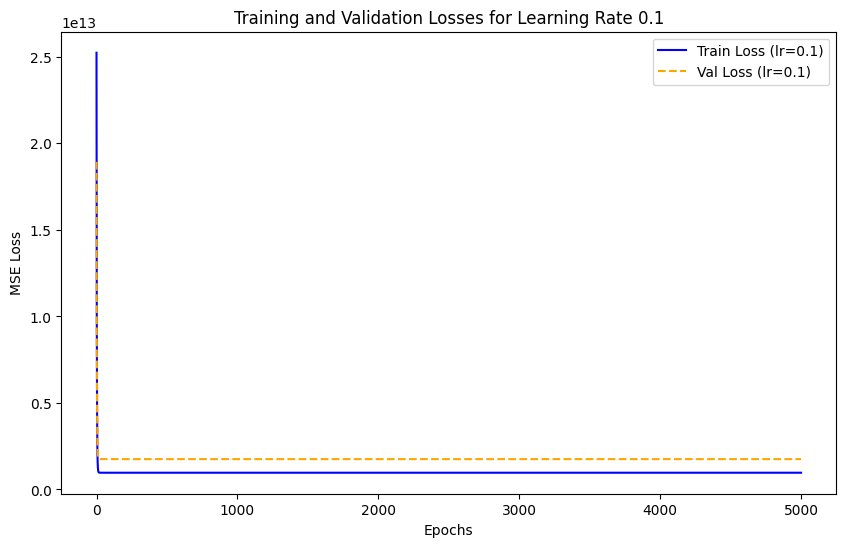

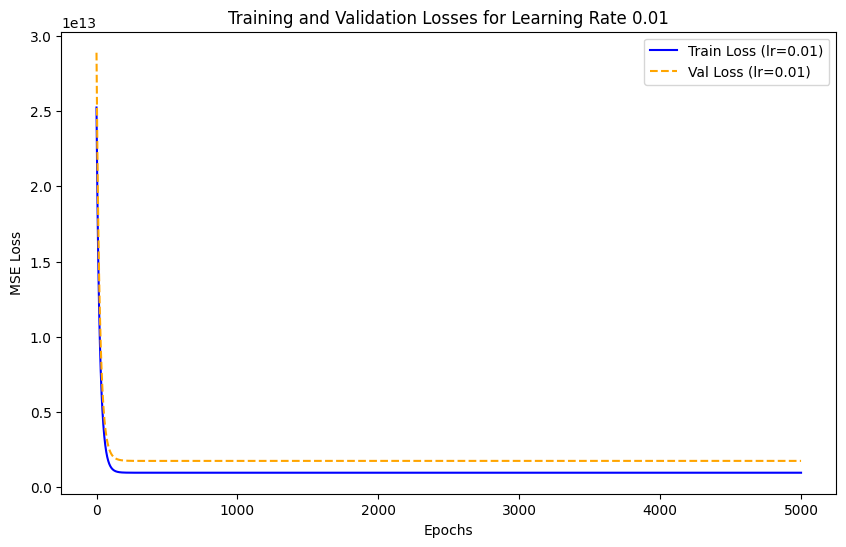

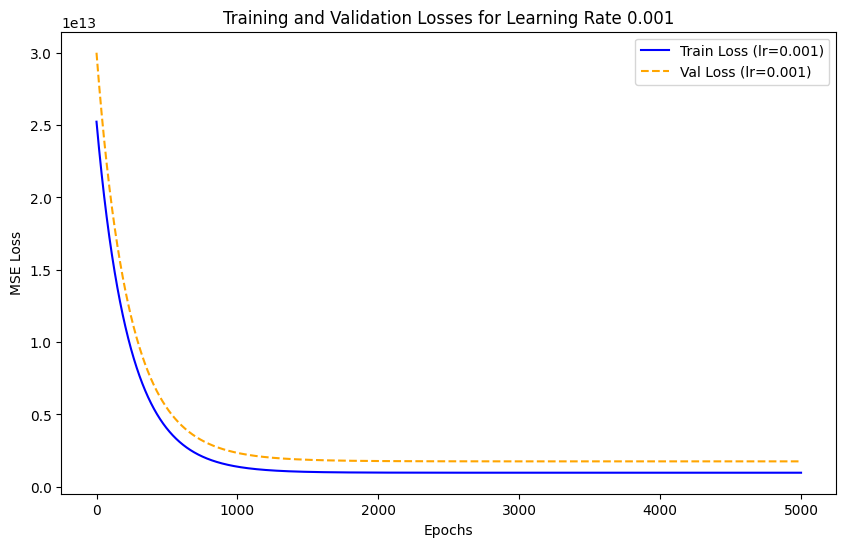

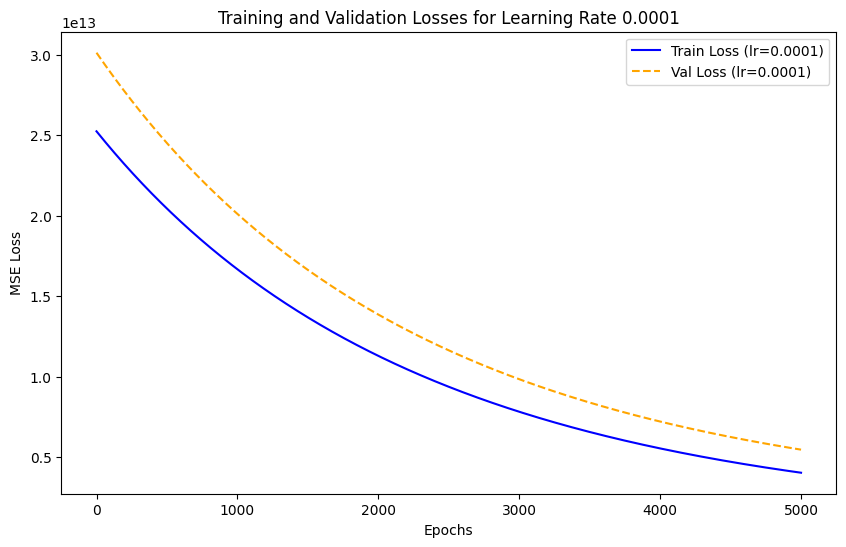


Best Validation Loss from current model: 1753792249856.0000


In [2]:
################################
########### Problem 3 ##########
################################
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv'
df = pd.read_csv(url)

# Select all columns as features except for the target variable
target = 'price'

# Encode categorical variables
categorical_features = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Update features to include all columns except target
features = [col for col in df.columns if col != target]

# Handle missing values if any
df = df.dropna(subset=features + [target])

# Split the data into training and validation sets (80% training, 20% validation)
X = df.drop(columns=target).values
y = df[target].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_tensor.shape[1]
criterion = nn.MSELoss()

# Training function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, n_epochs=5000, report_interval=500):
    train_losses = []
    val_losses = []
    for epoch in range(1, n_epochs + 1):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Report losses
        if epoch % report_interval == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    return train_losses, val_losses

# Training with different learning rates and store losses
learning_rates = [0.1, 0.01, 0.001, 0.0001]
best_val_loss = float('inf')
best_model_state = None
all_train_losses = {}
all_val_losses = {}

for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')
    model = LinearRegressionModel(input_dim)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses, val_losses = train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

    # Store losses for plotting
    all_train_losses[lr] = train_losses
    all_val_losses[lr] = val_losses

    # Check if this is the best model
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_model_state = model.state_dict()

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(12, 6))
# Plot separate graphs for each learning rate
for lr in learning_rates:
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_losses[lr], label=f'Train Loss (lr={lr})', color='blue')
    plt.plot(all_val_losses[lr], linestyle='--', label=f'Val Loss (lr={lr})', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title(f'Training and Validation Losses for Learning Rate {lr}')
    plt.legend()
    plt.show()


# Load the best model
best_model = LinearRegressionModel(input_dim)
best_model.load_state_dict(best_model_state)

# Print the best validation loss
print(f'\nBest Validation Loss from current model: {best_val_loss:.4f}')
